## Imports

In [ ]:
# standard library


# third party
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import torch
import torch.nn.functional as F


# application/library specific
from functools import partial
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from torch import nn
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator


/Users/diegocardona/repositorios/NLP_nequi_test_diegocardona/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Variables Globales

In [ ]:
TARGET = "label"
FEATURE = "narrative"
EMBEDDING_SIZES = 100

# hiperparámetros
EPOCHS = 6 # pocas porque se tiene un gpu pequeño y el modelo se ve bueno
TASA_APRENDIZAJE = 0.015 # se puede experimentar con otros, tradicionalmente 0.1, agresivo 0.3
BATCH_TAMANO = 82 # aprovechando la gpu

In [2]:
path_data = "../dataset/complaints.csv"

df = pd.read_csv(path_data, index_col=0)
df.reset_index(drop=True, inplace=True)

In [3]:
df.head()

,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?
0,Credit Reporting,Dear Possible Financial Inc you guyss aree rep...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Incorrect information on your report,Account information incorrect,Possible Financial Inc,MI,Yes
1,Debt Collection,"XXXX XXXX XXXX ( debt collector ), sent my boy...",Debt collection,2024-07-27,I do not know,Threatened to contact someone or share informa...,Talked to a third-party about your debt,BlueChip Financial,TX,Yes
2,Credit Reporting,I been receiving alerts my information was fou...,Credit reporting or other personal consumer re...,2024-07-23,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,FC HoldCo LLC,SC,Yes
3,Credit Reporting,Subject : Dispute of Inaccurate Information on...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,GA,Yes
4,Loans,They allowed me to use the account for about a...,"Payday loan, title loan, personal loan, or adv...",2024-07-26,Payday loan,Received a loan you didn't apply for,NaN,MoneyLion Inc.,PA,Yes


In [ ]:
pd.set_option("display.max_colwidth", None) # para aumentar la visualización del dataframe

In [5]:
df[["narrative", "product_5"]][df.product_5 == "Loans"].head()

narrative  \
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        They allowed me to use the

In [6]:
df.shape

(2023066, 10)

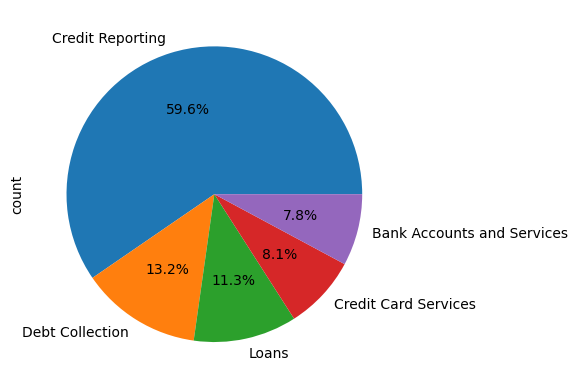

In [7]:
df.product_5.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

### Balanceo del dataframe para quitarle peso a la clase "Credit Reporting"

In [8]:
df_creditreporting = df[df.product_5 == "Credit Reporting"]
df_debtcollection = df[df.product_5 == "Debt Collection"]
df_minorityclass = df[df.product_5 != "Credit Reporting"]

df_creditreporting_balanced = resample(
    df_creditreporting,
    replace=False,
    n_samples=len(df_debtcollection),
    random_state=1
)

df_vproportional = pd.concat([df_creditreporting_balanced, df_minorityclass])

In [9]:
le = LabelEncoder()

df_vproportional["label"] = le.fit_transform(df_vproportional["product_5"])

### Separación de datos en entrenamiento, evaluación (dev) y test

In [10]:
train_df, test_df = train_test_split(df_vproportional, test_size=0.2, stratify=df_vproportional['label'])
train_df, dev_df = train_test_split(train_df, test_size=0.25, stratify=train_df['label'])

### Observación de la proporción de datos por cada clase

In [11]:
train_df.product_5.value_counts(normalize=True).sort_index().mul(100).round(1).astype(str)+'%'

product_5
Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object

In [13]:
test_df.product_5.value_counts(normalize=True).sort_index().mul(100).round(1).astype(str)+'%'

product_5
Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object

In [14]:
dev_df.product_5.value_counts(normalize=True).sort_index().mul(100).round(1).astype(str)+'%'

product_5
Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object

## Modelo de Clasificación con Pytorch

In [ ]:
print(torch.__version__)

2.1.0


### Uso de la GPU de Macbook en caso de tener

In [35]:
if torch.backends.mps.is_available():
    print("MPS available")
else:
    print("MPS ERROR!!")

MPS available


In [36]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Funciones y Clases Auxiliares

In [46]:
def tokenizador_full(text, base_tokenizer, stop_words):
    return [token for token in base_tokenizer(text) if token not in stop_words]

In [29]:
def yield_tokens(data_iter, tokenizador, base_tokenizer, stop_words):
    for texto in data_iter:
        yield tokenizador(texto, base_tokenizer, stop_words)

In [ ]:
def collate_batch(batch, device=device):
    text_list, label_list = [], []
    for text, label in batch:
        text_list.append(text)
        label_list.append(label)
    # pad_sequence convierte a (batch_size, max_len)
    text_padded = pad_sequence(text_list, batch_first=True, padding_value=0)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return labels.to(device), text_padded.to(device)

In [60]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [62]:
# función para entrenar el modelo
def entrena(dataloader, modelo, optimizer, criterio, epoch):
  # poner el modelo en formato de entrenamiento
  modelo.train()

  # inicialización de variables para hacer seguimiento a la mejora del modelo
  # accuracy
  epoch_acc = 0
  # perdida
  epoch_loss = 0
  # cuántos ejemplos tiene el batch del dataloader
  total_count = 0

  # for idx, (label, text, offsets) in enumerate(dataloader):
  for idx, (label, text) in enumerate(dataloader):
    # reestablecer los gradientes después de cada batch
    optimizer.zero_grad()
    # predicciones
    # prediccion = modelo(text, offsets)
    prediccion = modelo(text)

    # obtención de la pérdida
    loss = criterio(prediccion, label)

    # backpropage: hacia atrás se obtiene la derivada y calcula los pesos
    loss.backward()

    # accuracy, calcula el porcentaje de correctos
    acc = (prediccion.argmax(1) == label).sum()

    # evitar que los gradientes sean demaciado rápidos
    torch.nn.utils.clip_grad_norm(modelo.parameters(), 0.1)

    # optimizar los pesos
    optimizer.step()

    torch.mps.empty_cache()

    # llevamos el conteo de la pérdida y el accuracy
    epoch_acc += acc.item()
    epoch_loss += loss.item()
    total_count += label.size(0)

    if idx % 500 == 0 and idx > 0:
      print(f'epoca {epoch} | {idx}/{len(dataloader)} batches | perdida {epoch_loss/total_count} | accuracy {epoch_acc/ total_count}')

  return epoch_acc/total_count, epoch_loss/total_count

In [63]:
# Función para evaluar el modelo
def evalua(dataloader, modelo, criterio):
  modelo.eval()
  # modelo.cuda()
  epoch_acc = 0
  epoch_loss = 0
  total_count = 0

  # cuando se va a evaluar un modelo o hacer inferencia, se debe referenciar
  # que no se haga gradiente, es decir no se entrene
  with torch.no_grad():
    # for idx, (label, text, offsets) in enumerate(dataloader):
    for idx, (label, text) in enumerate(dataloader):
      # prediccion = modelo(text, offsets)
      prediccion = modelo(text)

      loss = criterio(prediccion, label)
      acc = (prediccion.argmax(1) == label).sum()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      total_count += label.size(0)

    return epoch_acc/total_count, epoch_loss/total_count

In [77]:
def predict(text, texto_pipeline, model):
  with torch.no_grad():
    text_ids = texto_pipeline(text)
    text_tensor = torch.tensor([text_ids], dtype=torch.long)
    text_tensor = text_tensor.to(next(model.parameters()).device)
    output = model(text_tensor)
  return output.argmax(1).item()

In [34]:
class TextDataset(Dataset):
    def __init__(self, df, vocab, tokenizer):
        self.labels = df[TARGET].values
        self.texts = df[FEATURE].values
        self.vocab = vocab
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        token_ids = self.vocab(tokens)
        return torch.tensor(token_ids), torch.tensor(self.labels[idx])

In [ ]:
class ModeloClasificacionTexto(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(ModeloClasificacionTexto, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bn1 = nn.BatchNorm1d(embed_dim)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text_batch):
        embedded = self.embedding(text_batch)  # (batch_size, seq_len, embed_dim)
        embedded = embedded.mean(dim=1)  # (batch_size, embed_dim)
        embedded_norm = self.bn1(embedded)
        activated = F.relu(embedded_norm)
        return self.fc(activated)

In [18]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegocardona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
base_tokenizer = get_tokenizer("basic_english")

In [21]:
pd.reset_option("display.max_colwidth") # para acortar la visualización del dataframe

train_df.head()

,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?,label
1348750,Credit Reporting,THESE ACCOUNTS ARE REPORTING INACCURATELY. PLE...,Credit reporting or other personal consumer re...,2024-05-14,Credit reporting,Incorrect information on your report,Information belongs to someone else,Experian Information Solutions Inc.,VA,Yes,2
1251065,Loans,We are filing a complaint with ocwen for faili...,Mortgage,2020-12-15,Other type of mortgage,Trouble during payment process,NaN,Onity Group Inc.,CT,Yes,4
585568,Debt Collection,I continually receive a phone call stating tha...,Debt collection,2019-05-06,Credit card debt,Communication tactics,"Used obscene, profane, or other abusive language",HSBC NORTH AMERICA HOLDINGS INC.,PA,Yes,3
1766848,Debt Collection,Statute of limitation expire but they keep har...,Debt collection,2016-03-15,Credit card,Taking/threatening an illegal action,Threatened to sue on too old debt,"CAVALRY INVESTMENTS, LLC",NY,Yes,3
621517,Credit Reporting,After multiple of disputes no information prov...,"Credit reporting, credit repair services, or o...",2021-07-20,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Santander Consumer USA Holdings Inc.,NY,Yes,2


In [22]:
df_vproportional.label.value_counts()

label
2    266842
3    266842
4    228599
1    163710
0    158640
Name: count, dtype: int64

In [23]:
le.classes_

array(['Bank Accounts and Services', 'Credit Card Services',
       'Credit Reporting', 'Debt Collection', 'Loans'], dtype=object)

In [22]:
le.inverse_transform([0])

array(['Bank Accounts and Services'], dtype=object)

In [49]:
vocab = build_vocab_from_iterator(
    yield_tokens(df_vproportional["narrative"], tokenizador_full, base_tokenizer, stop_words),
    min_freq=3,
    specials=["<unk>"],
    special_first=True,
    max_tokens=10000
    )

vocab.set_default_index(vocab["<unk>"])

In [79]:
label_pipeline = lambda x: x

texto_pipeline = lambda x: vocab(tokenizador_full(x, base_tokenizer, stop_words))

In [47]:
tokenizador = partial(tokenizador_full, base_tokenizer=base_tokenizer, stop_words=stop_words)

dataset_train = TextDataset(train_df, vocab, tokenizador)
dataloader_train = DataLoader(dataset_train, batch_size=82, shuffle=True, collate_fn=collate_batch)

dataset_test = TextDataset(test_df, vocab, tokenizador)
dataloader_test = DataLoader(dataset_test, batch_size=82, shuffle=True, collate_fn=collate_batch)

dataset_dev = TextDataset(dev_df, vocab, tokenizador)
dataloader_dev = DataLoader(dataset_dev, batch_size=82, shuffle=True, collate_fn=collate_batch)

In [50]:
next(iter(dataset_train))

(tensor([  32,   22, 1581,    1,   51,  125,    1]), tensor(2))

In [51]:
type(dataset_train)

__main__.TextDataset

In [35]:
len(vocab)

10000

In [55]:
# con set() elimino repetidos y obtengo el numero de clases en el dataset
num_class = len(set(train_df.label))
vocab_size = len(vocab)
embedding_size = EMBEDDING_SIZES

modelo = ModeloClasificacionTexto(vocab_size=vocab_size, embed_dim=embedding_size, num_class=num_class).to(device)

In [56]:
num_class

5

In [59]:
print(modelo)

ModeloClasificacionTexto(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)


In [61]:
print(f'El modelo tiene {count_parameters(modelo):,} parámetros entrenables')

El modelo tiene 1,000,705 parámetros entrenables


In [65]:
# función de pérdida
criterio = torch.nn.CrossEntropyLoss() # la convencción para llamar la función de pérdida es nombrarla criterio
# optimizer = torch.optim.SGD(modelo.parameters(), lr=TASA_APRENDIZAJE)
optimizer = torch.optim.Adam(modelo.parameters(), lr=TASA_APRENDIZAJE)

In [45]:
print(dataset_train)

In [66]:
len(dataloader_train)

7937

In [67]:
len(dataloader_test)

2646

In [68]:
len(dataloader_dev)

2646

In [69]:
next(iter(dataloader_train))

(tensor([3, 3, 1, 4, 2, 0, 2, 0, 4, 0, 3, 0, 2, 0, 2, 1, 2, 4, 2, 2, 2, 3, 3, 4,
         1, 3, 3, 3, 2, 0, 3, 1, 0, 1, 3, 3, 3, 2, 1, 4, 0, 1, 2, 4, 3, 0, 0, 2,
         2, 2, 3, 2, 1, 1, 0, 2, 2, 4, 3, 0, 0, 2, 3, 4, 3, 2, 1, 3, 1, 2, 1, 2,
         3, 2, 3, 3, 3, 2, 3, 0, 2, 3], device='mps:0'),
 tensor([[ 283,    0,   47,  ...,    0,    0,    0],
         [  39,   39,    0,  ...,    0,    0,    0],
         [ 116, 2581,  653,  ...,    0,    0,    0],
         ...,
         [ 128,  351,  181,  ...,    0,    0,    0],
         [ 298,   11,  176,  ...,    0,    0,    0],
         [  47,   16,    0,  ...,    0,    0,    0]], device='mps:0'))

### Segunda revisión de la proporción de clases antes de entrenar el modelo

In [70]:
category_mapping = {i: label for i, label in enumerate(le.classes_)}

In [71]:
labels_train = [label for label, _ in dataloader_train]  
labels_train = torch.cat(labels_train).cpu().numpy()

percentage_train_class = (
    pd.Series(labels_train)
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(1)
    .astype(str) + '%'
    )

percentage_train_class = percentage_train_class.rename(index=category_mapping)

print(percentage_train_class)

Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object


In [72]:
labels_valid = [label for label, _ in dataloader_test]
labels_valid = torch.cat(labels_valid).cpu().numpy()

percentage_valid_class = (
    pd.Series(labels_valid)
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

percentage_valid_class = percentage_valid_class.rename(index=category_mapping)

print(percentage_valid_class)

Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object


In [73]:
dataloader_val = dataloader_dev # cambio de nombre por datos de validación
labels_test = [label for label, _ in dataloader_val]
labels_test = torch.cat(labels_test).cpu().numpy()

percentage_test_class = (
    pd.Series(labels_test)
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

percentage_test_class = percentage_test_class.rename(index=category_mapping)

print(percentage_test_class)

Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object


### Ejecución del entrenamiento del modelo

In [74]:
# obtención de la mejor pérdida, cuál es el que da el valor más pequeño de pérdida
major_loss_validation = float('inf') # inf: que puede tomar muchos valores diferentes

# Entrenamos
for epoch in range(1, EPOCHS+1):
  # entrenamiento
  entrenamiento_acc, entrenamiento_loss = entrena(dataloader_train, modelo, optimizer, criterio, epoch)

  # validación
  validacion_acc, validacion_loss = evalua(dataloader_val, modelo, criterio)

  # guardamos el modelo con los mejores pesos
  # si la pérdida del modelo de validación es menor que el major_loss_validation
  if validacion_loss < major_loss_validation:
    best_valid_loss = validacion_loss
    torch.save(modelo.state_dict(), "mejores_pesos_guardados.pt") # modelo Pytorch termina en .pt

/var/folders/8x/shhvyxrd77s8h2qsqg9jtg5m0000gn/T/ipykernel_68581/1758233626.py:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(modelo.parameters(), 0.1)


epoca 1 | 500/7937 batches | perdida 0.008125622144466679 | accuracy 0.7677084854680882
epoca 1 | 1000/7937 batches | perdida 0.007410723342683702 | accuracy 0.7914646329280476
epoca 1 | 1500/7937 batches | perdida 0.007021511416889601 | accuracy 0.8032693651386881
epoca 1 | 2000/7937 batches | perdida 0.006774757239649322 | accuracy 0.8104362452919881
epoca 1 | 2500/7937 batches | perdida 0.006641923721144297 | accuracy 0.8140158570718055
epoca 1 | 3000/7937 batches | perdida 0.006525107246173891 | accuracy 0.8178249526580571
epoca 1 | 3500/7937 batches | perdida 0.006418516466603649 | accuracy 0.8211242780808271
epoca 1 | 4000/7937 batches | perdida 0.006337073674250131 | accuracy 0.8235989783042045
epoca 1 | 4500/7937 batches | perdida 0.006274236385501801 | accuracy 0.8255943123750278
epoca 1 | 5000/7937 batches | perdida 0.006214607396544036 | accuracy 0.8273052706531865
epoca 1 | 5500/7937 batches | perdida 0.006171158491251977 | accuracy 0.828583273107772
epoca 1 | 6000/7937 bat

In [76]:
# Evaluación del modelo
test_acc, test_loss = evalua(dataloader_test, modelo, criterio)

# aquí se evalua si el modelo aprendió de forma correcta, si es bueno generalizando
print(f'Accuracy del test dataset -> {test_acc}')
print(f'Pérdida del test dataset -> {test_loss}')

Accuracy del test dataset -> 0.8223872546985852
Pérdida del test dataset -> 0.0064647285887579195


### Pruebas de Inferencia

In [81]:
# Traemos el mapeo entre entero encodizado y su clase string correspondiente
category_mapping = {i: label for i, label in enumerate(le.classes_)}

ejemplo_1 = "I have a problem with my credit report"

model = modelo.to("cpu") # no es necesario gpu

print(f'El emeplo 1 es de categoría {category_mapping[predict(ejemplo_1, texto_pipeline, model)]}')

El emeplo 1 es de categoría Credit Reporting


In [83]:
ejemplo_2 = "Can you help me with a credit card for my job?"

print(f'El emeplo 2 es de categoría {category_mapping[predict(ejemplo_2, texto_pipeline, model)]}')

El emeplo 2 es de categoría Credit Card Services


In [85]:
ejemplo_3 = "Loans Loans loans I have many loans"

print(f'El ejemplo 3 es de {category_mapping[predict(ejemplo_3, texto_pipeline, model)]}')

El ejemplo 3 es de Loans


### Almacenamiento local del modelo

In [ ]:
# se usará el método state_dict() para extraer todos los parámetros (pesos) del model entrenado
# y poderlo usar en otros modelos cuando queramos.
# Nos ayuda a guardar el modelo, para seguirlo entrenando o realizar inferencia

model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()

# checkpoint o punto de guardado para futuros usos

checkpoint = {
    "model_state_dict" : model_state_dict,
    "optimizer_state_dict" : optimizer_state_dict,
    "epoch" : epoch,
    "loss" : entrenamiento_loss
}

torch.save(checkpoint, "model_checkpoint.pth") # pth o pt pueden usarse

torch.save(vocab, "vocab.pt") # Almacenamiento del vocabulario

In [99]:
def predict_proba(text, texto_pipeline, model):
  with torch.no_grad():
    text_ids = texto_pipeline(text)
    text_tensor = torch.tensor([text_ids], dtype=torch.long)
    text_tensor = text_tensor.to(next(model.parameters()).device)
    output = model(text_tensor)
  return output # .argmax(1).item()

In [110]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np

In [111]:
def plot_multiclass_precision_recall(
    y_score, y_true_untransformed, class_list, classifier_name
):
    """
    Precision-Recall plotting for a multiclass problem. It plots average precision-recall, per class precision recall and reference f1 contours.

    Code slightly modified, but heavily based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    n_classes = len(class_list)
    y_true = pd.concat(
        [(y_true_untransformed == class_list[i]) for i in range(n_classes)], axis=1
    ).values

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision_micro, recall_micro, _ = precision_recall_curve(
        y_true.ravel(), y_score.ravel()
    )
    average_precision_micro = average_precision_score(y_true, y_score, average="micro")
    print(
        str(classifier_name)
        + " - Average precision score over all classes: {0:0.2f}".format(
            average_precision_micro
        )
    )

    # setup plot details
    plt.figure(figsize=(9, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append("iso-f1 curves")
    (l,) = plt.plot(recall_micro, precision_micro, color="gold", lw=2)
    lines.append(l)
    labels.append(
        "average Precision-recall (auprc = {0:0.2f})" "".format(average_precision_micro)
    )

    for i in range(n_classes):
        (l,) = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append(
            "Precision-recall for class `{0}` (auprc = {1:0.2f})"
            "".format(class_list[i], average_precision[i])
        )

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{classifier_name}: Precision-Recall curve for each class")
    plt.legend(lines, labels)

In [ ]:
# EJEMPLO DE CÓMO DEBEN SER LOS DATOS PARA EL PLOT DE RECALL-PRECISION

# num_probas = [[0.8, 0.45], [0.75,0.23], [0.98,0.69], [0.8,0.6], [0.7,0.9]]
# probas = np.array(num_probas)

# y_values = [1,1,2,1,2]
# y_test = pd.DataFrame(y_values)

# clf = "Modelo_ejemplo"

In [122]:
principal_columns = ["narrative", "product_5", "label"]

df_test_analysis = test_df.copy()
df_test_analysis = df_test_analysis[principal_columns]
df_test_analysis = df_test_analysis.reset_index()
df_test_analysis.head()

,index,narrative,product_5,label
0,1058216,"At the beginning of XX/XX/2018, my mother and ...",Loans,4
1,673293,I have contacted the creditor/company many tim...,Debt Collection,3
2,1935595,not only have the debt collectors be argumenta...,Debt Collection,3
3,1522322,"Hello, On XX/XX/XXXX I had made a call to my W...",Credit Card Services,1
4,439929,I am XXXX XXXX XXXX and I am a natural living ...,Credit Reporting,2


In [123]:
df_test_analysis.shape

(216927, 4)

In [127]:
df_test_analysis.drop(["index"], axis=1, inplace=True)

In [128]:
df_test_analysis.head()

,narrative,product_5,label
0,"At the beginning of XX/XX/2018, my mother and ...",Loans,4
1,I have contacted the creditor/company many tim...,Debt Collection,3
2,not only have the debt collectors be argumenta...,Debt Collection,3
3,"Hello, On XX/XX/XXXX I had made a call to my W...",Credit Card Services,1
4,I am XXXX XXXX XXXX and I am a natural living ...,Credit Reporting,2


In [ ]:
def transformacion1(x):
    if x < 0:
        x = 0
        return x
    else:
        return x

In [215]:
def transformacion2(list):
    epsilon = 0.0001
    valor_maximo = max(list)
    valor_minimo = min(list)
    normalizacion = [(n-valor_minimo)/max(valor_maximo-valor_minimo, epsilon) for n in list]
    return normalizacion

In [217]:
p_proba = list()

for text in df_test_analysis.drop(["product_5", "label"], axis=1).values:
    text_to_predict = text[0]
    p = predict_proba(text_to_predict, texto_pipeline, model)[0].tolist()
    p = list(map(transformacion1, p))
    p = transformacion2(p)
    p = [round(x, 2) for x in p]
    p_proba.append(p)

In [218]:
y_true = pd.DataFrame(df_test_analysis.label)

In [219]:
probas = np.array(p_proba)

Red Neuronal - Average precision score over all classes: 0.81


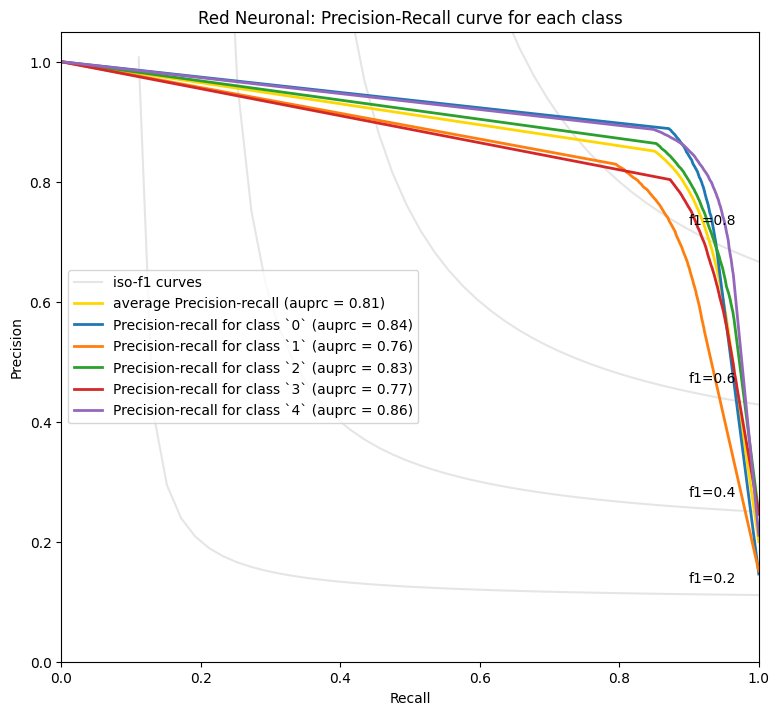

In [221]:
clf = "Red Neuronal"

plot_multiclass_precision_recall(probas, y_true, [0,1,2,3,4], clf)

In [223]:
category_mapping

{0: 'Bank Accounts and Services',
 1: 'Credit Card Services',
 2: 'Credit Reporting',
 3: 'Debt Collection',
 4: 'Loans'}

#### NOTA: el siguiente análisis es con base al resultado del modelo generado 2025/05/08 si el análisis no coincide con la gráfica es porque se volvió a correr, pero el análisis sirve como base para identificar uno nuevo.

La gráfica anterior, contiene la comparativa de Precision vs Recall, en donde para cada clase del modelo entrenado se tiene una linea coloreada correspondientes a cada una de las clases. Mientras más cercana este una linea coloreada al punto coordenado (1,1), mejor será la calificación de la clase. Es decir, que el modelo va a realizar una predicción más precisa con respecto a dicha clase. Así pues, si todas las lineas coloreadas están muy cerca de la coordenada (1,1) esto quire decir que nuestro modelo predice muy bien todas las clases.

Lo que observamos, es que las clases 1: Credit Card Services y 2: Credit Reporting, son las de más bajo nivel de precisión a la hora de predecir, mientras que las de más clases se predicen con una buena confiabilidad.

Por otra parte, también se graficaron las lineas iso-f1 o líneas del F1-score, estas representan la media armónica entre las métricas precision y recall, lo cual nos dice qué tan buena es la clase en general juntando las dos primeras métricas comentadas. Para cada clase la iso-f1 corresponderá a la curva que más se acerque, en este caso vemos que todas las curvas de colores/clases superan la barrera de la f1=0.80, por lo tanto tenemos en general un modelo que tiene un buen nivel de confianza para hacer sus predicciones.

Finalmente, se cuenta con un promedio de precision-recall del 0.81 que reafirma un modelo aceptable.